<a href="https://colab.research.google.com/github/matshch/iu5_bi_course/blob/master/lab2/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2
## Задача №2
### Условие
Шест прикреплен неуправляемым шарниром к&nbsp;тележке, которая движется по&nbsp;бесфрикционному пути. Маятник начинает двигаться вертикально, и цель состоит в&nbsp;том, чтобы предотвратить его падение, увеличивая и уменьшая скорость тележки.

#### Наблюдения
Номер | Наблюдение                | Минимум          | Максимум
----- | ------------------------- | ---------------- | --------
0     | Позиция тележки           | &minus;2,4       | +2,4
1     | Скорость тележки          | &minus;&infin;   | +&infin;
2     | Угол шеста                | &minus;41,8&deg; | +41,8&deg;
3     | Скорость шеста на кончике | &minus;&infin;   | +&infin;

#### Действия
Номер | Действие
----- | --------
0     | Толкнуть тележку влево
1     | Толкнуть тележку вправо

Примечание: величина, на&nbsp;которую скорость уменьшается или увеличивается, не&nbsp;является фиксированной, поскольку она зависит от&nbsp;угла, на&nbsp;который указывает шест. Это происходит потому, что центр тяжести полюса увеличивает количество энергии, необходимой для&nbsp;перемещения тележки под&nbsp;ним.

#### Награда
Вознаграждение составляет 1 за каждый сделанный шаг, включая последний шаг.

#### Начальное состояние
Всем наблюдениям присваивается равномерное случайное значение в&nbsp;пределах &pm;0,05.

#### Окончание эпизода
1. Угол шеста больше, чем &pm;12&deg;.
2. Положение тележки больше &pm;2,4 (центр тележки достигает края дисплея).
3. Длина эпизода больше 200.

#### Требования решения
Считается решенным, когда среднее вознаграждение больше или равно 195,0 в&nbsp;течение 100&nbsp;последовательных испытаний.

### Решение
Импортируем все необходимые пакеты:

In [1]:
!pip install git+https://github.com/google-research/tf-slim

  Cloning https://github.com/google-research/tf-slim to /tmp/pip-req-build-6beesfel
  Running command git clone -q https://github.com/google-research/tf-slim /tmp/pip-req-build-6beesfel
  Created wheel for tf-slim: filename=tf_slim-1.1-cp36-none-any.whl size=357897 sha256=ffa56e5900dad05a97587501255fe0941143b8e3621e4239a0a86ec56ef245ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3niztu3/wheels/bb/98/dc/eba6500d756d16f6ff371b39ed733d26cec1b0b0085e1cb0df
Successfully built tf-slim


In [2]:
import tensorflow.compat.v1 as tf
import tqdm.notebook as tqdm
import tf_slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Загрузим необходимое по условию окружение:

In [0]:
env = gym.make('CartPole-v0')

Напишем функцию, подсчитывающую награду:

In [0]:
gamma = 0.99

def discount_rewards(r):
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

Определим класс агента, который будет работать в описанной выше среде.

In [0]:
class agent():
  def __init__(self, lr, s_size, a_size, h_size):
    self.state_in= tf.placeholder(shape=[None, s_size], dtype=tf.float32)
    hidden = tf_slim.fully_connected(self.state_in, h_size, biases_initializer=None, activation_fn=tf.nn.relu)
    self.output = tf_slim.fully_connected(hidden, a_size, activation_fn=tf.nn.softmax, biases_initializer=None)
    self.chosen_action = tf.argmax(self.output, 1)

    self.reward_holder = tf.placeholder(shape=[None], dtype=tf.float32)
    self.action_holder = tf.placeholder(shape=[None], dtype=tf.int32)

    self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
    self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

    self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs) * self.reward_holder)

    tvars = tf.trainable_variables()
    self.gradient_holders = []
    for idx,var in enumerate(tvars):
      placeholder = tf.placeholder(tf.float32,name=str(idx) + "_holder")
      self.gradient_holders.append(placeholder)

    self.gradients = tf.gradients(self.loss, tvars)

    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders, tvars))

Обучаем агента:

In [6]:
tf.reset_default_graph()

myAgent = agent(lr=1e-2, s_size=4, a_size=2, h_size=8)

total_episodes = 5000
max_ep = 200
update_frequency = 10

init = tf.global_variables_initializer()

with tf.Session() as sess:
  with tqdm.tqdm(total=total_episodes) as progress:
    sess.run(init)
    i = 0
    total_reward = []
    total_length = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix, grad in enumerate(gradBuffer):
      gradBuffer[ix] = 0

    while i < total_episodes:
      s = env.reset()
      running_reward = 0
      ep_history = []
      for j in range(max_ep):
        a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
        a = np.random.choice(a_dist[0],p=a_dist[0])
        a = np.argmax(a_dist == a)

        s1, r, done, _ = env.step(a)
        ep_history.append([s, a, r, s1])
        s = s1
        running_reward += r
        if done == True:
          ep_history = np.array(ep_history)
          ep_history[:,2] = discount_rewards(ep_history[:,2])
          feed_dict = {
              myAgent.reward_holder: ep_history[:,2],
              myAgent.action_holder: ep_history[:,1],
              myAgent.state_in:      np.vstack(ep_history[:,0])
            }
          grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
          for idx, grad in enumerate(grads):
            gradBuffer[idx] += grad

          if i % update_frequency == 0 and i != 0:
            feed_dict = dict(zip(myAgent.gradient_holders, gradBuffer))
            sess.run(myAgent.update_batch, feed_dict=feed_dict)
            for ix, grad in enumerate(gradBuffer):
              gradBuffer[ix] = 0

          total_reward.append(running_reward)
          total_length.append(j)
          break

      if i % 100 == 0:
        progress.set_postfix({
            "mean_reward": np.mean(total_reward[-100:])
        })
      i += 1
      progress.update()

Instructions for updating:
Please use `layer.__call__` method instead.


Посмотрим на график наград:

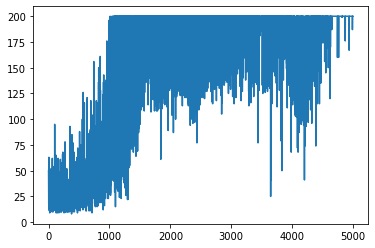

In [7]:
plt.plot(total_reward)

Видно, что к концу обучения мы получили достаточно хорошие результаты:

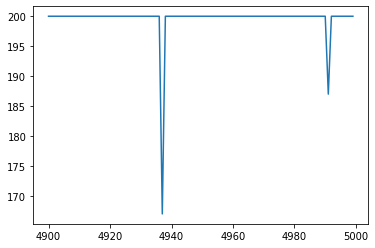

In [8]:
x = range(4900, 5000)
y = total_reward[4900:5000]
plt.plot(x, y)

### Вывод
Данный код выполняет условия задачи.